In [ ]:
!pip install geopandas
!pip install contextily
#!pip list
#!nvcc --version
!pip install scalecast --upgrade

!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mon Jun  5 05:31:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W

In [ ]:
# Importaciones de bibliotecas estándar de Python
from datetime import datetime, timedelta

# Importaciones de bibliotecas de terceros
import pandas as pd
import numpy as np
import geopandas as gpd
import pickle
import unicodedata
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers, Model
from tensorflow.python.keras.optimizers import adam_v2
from tensorflow.python.keras.metrics import Mean
from keras.losses import MeanSquaredError
from google.colab import drive
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [ ]:
tf.config.list_physical_devices('GPU')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gdf=gpd.read_file("/content/drive/MyDrive/PDG/data/MGN2021_MPIO_POLITICO/MGN_MPIO_POLITICO.shp")
def remove_accents_and_uppercase(text):
    if not isinstance(text, str):
        return text

    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    return text.upper()

columnas_a_transformar_colombia = ["DPTO_CNMBR", "MPIO_CNMBR"]
gdf[columnas_a_transformar_colombia]=gdf[columnas_a_transformar_colombia].applymap(remove_accents_and_uppercase)
gdf = gdf.to_crs('EPSG:3857')
gdf['latitud'] = gdf['geometry'].centroid.y
gdf_sorted = gdf.sort_values('latitud', ascending=False)
gdf_sorted = gdf_sorted.reset_index(drop=True)

In [ ]:
municipio_a_indice = {(row['DPTO_CNMBR'], row['MPIO_CNMBR']): i for i, row in gdf_sorted.iterrows()}

In [ ]:
feminicidios = pd.read_csv('/content/drive/MyDrive/MGN2021_MPIO_POLITICO/datos_observatorio_limpios.csv', encoding='utf-8', sep=',')

feminicidios['num_casos'] = feminicidios['num_casos'].astype(int)

feminicidios['fecha_en_prensa'] = pd.to_datetime(feminicidios['fecha_en_prensa'])

feminicidios.head()

,fecha_en_prensa,departamento,municipio,num_casos,num_casos_normalizado
0,2018-01-02,ANTIOQUIA,HISPANIA,1,0.00
1,2018-01-02,META,VILLAVICENCIO,1,0.00
2,2018-01-03,ANTIOQUIA,MEDELLIN,3,0.50
3,2018-01-03,VALLE DEL CAUCA,CALI,2,0.25
4,2018-01-05,CORDOBA,MONTERIA,1,0.00


In [ ]:
# Contar los valores únicos en la columna 'departamento' del DataFrame 'feminicidios'
num_departamentos_feminicidios = feminicidios['departamento'].nunique()
print("Número de departamentos únicos en 'feminicidios':", num_departamentos_feminicidios)

# Contar los valores únicos en la columna 'DPTO_CNMBR' del DataFrame 'gdf'
num_departamentos_gdf = gdf['DPTO_CNMBR'].nunique()
print("Número de departamentos únicos en 'gdf':", num_departamentos_gdf)


Número de departamentos únicos en 'feminicidios': 31
Número de departamentos únicos en 'gdf': 33


In [ ]:
feminicidios_dpt = feminicidios.copy()
feminicidios_departamentos = feminicidios_dpt.groupby(['fecha_en_prensa', 'departamento'])['num_casos'].sum().reset_index()
dataframes_departamentos = {}
for dep in feminicidios_departamentos['departamento'].unique():
    dataframes_departamentos[dep] = feminicidios_departamentos[feminicidios_departamentos['departamento'] == dep]

In [ ]:
models = ('mlr','elasticnet','knn','rf','gbt','xgboost','mlp')
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

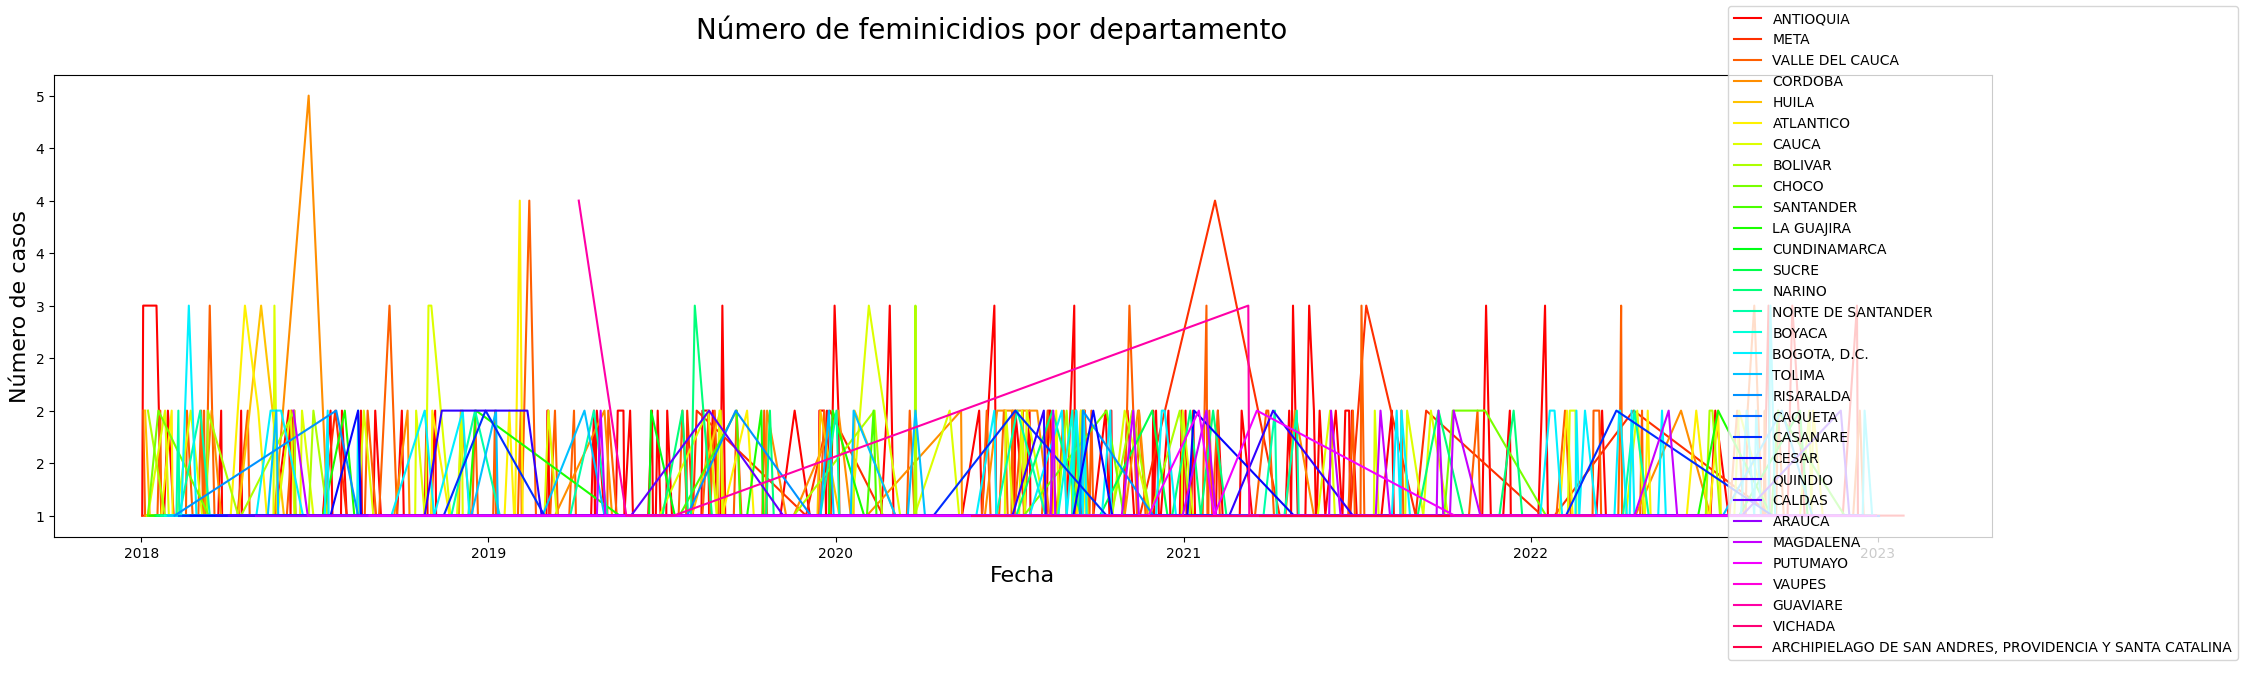

In [ ]:
fig, ax = plt.subplots(figsize=(25,6))
cmap = plt.get_cmap('hsv')

colors = [cmap(i/len(dataframes_departamentos)) for i in range(len(dataframes_departamentos))]

for i, (dep, df) in enumerate(dataframes_departamentos.items()):
    sns.lineplot(
        x='fecha_en_prensa',
        y='num_casos',
        data=df,
        label=dep,
        ax=ax,
        color=colors[i],
        legend=False
    )

ax.figure.legend()

plt.ylabel('Número de casos', size=16)
plt.xlabel('Fecha', size=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.suptitle('Número de feminicidios por departamento', size=20)
plt.show()

In [ ]:
frecuencia_por_departamento = feminicidios_dpt.groupby('departamento').apply(lambda x: x['fecha_en_prensa'].nunique())

top_departamentos = frecuencia_por_departamento.sort_values(ascending=False).head(2).index

print(top_departamentos)

Index(['ANTIOQUIA', 'VALLE DEL CAUCA'], dtype='object', name='departamento')


In [ ]:
data_antioquia = dataframes_departamentos['ANTIOQUIA']
data_valle = dataframes_departamentos['VALLE DEL CAUCA']

In [ ]:
all_dates = pd.date_range(start=feminicidios['fecha_en_prensa'].min(), end=feminicidios['fecha_en_prensa'].max())

data_antioquia = dataframes_departamentos['ANTIOQUIA'].set_index('fecha_en_prensa').reindex(all_dates).fillna(0).reset_index()
data_valle = dataframes_departamentos['VALLE DEL CAUCA'].set_index('fecha_en_prensa').reindex(all_dates).fillna(0).reset_index()

data_antioquia = data_antioquia.rename(columns={"index": "Fecha"})
data_valle = data_valle.rename(columns={"index": "Fecha"})

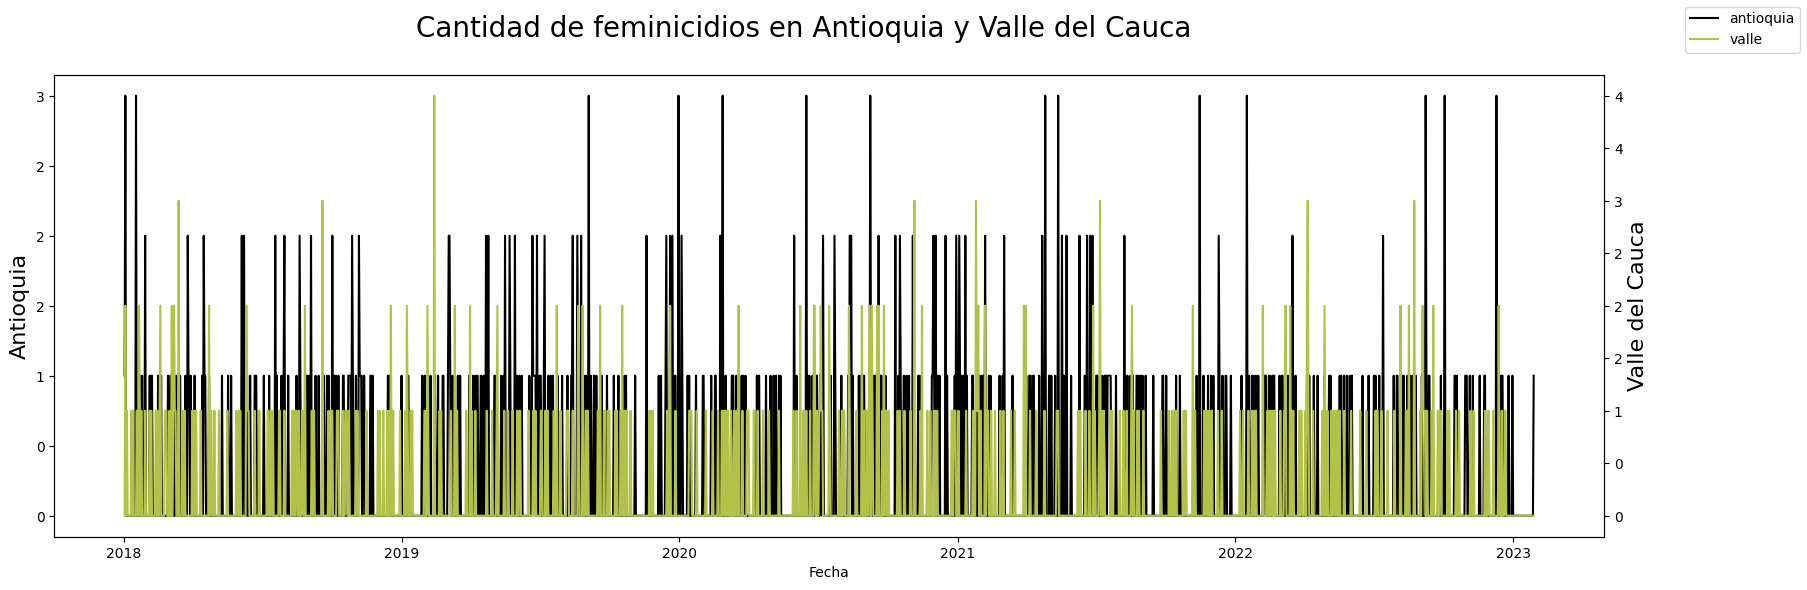

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
sns.lineplot(
    x='Fecha',
    y='num_casos',
    data=data_antioquia,
    label='antioquia',
    ax=ax,
    color='black',
    legend=False
)
plt.ylabel('Antioquia',size=16)
ax2 = ax.twinx()
sns.lineplot(
    x='Fecha',
    y='num_casos',
    data=data_valle,
    label='valle',
    ax=ax2,
    color='#B2C248',
    legend=False
)
ax.figure.legend()
plt.ylabel('Valle del Cauca',size=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.suptitle('Cantidad de feminicidios en Antioquia y Valle del Cauca',size=20)
plt.show()

In [ ]:
corr = np.corrcoef(data_antioquia['num_casos'].values,data_valle['num_casos'].values)[0,1]
print('{:.2%}'.format(corr))

-0.69%


In [ ]:
fanti = Forecaster(
    y=data_antioquia['num_casos'],
    current_dates = data_antioquia['Fecha'],
    test_length = .4,
    future_dates = 60,
    validation_length = 4,
    metrics = ['rmse','r2'],
    cis = True,
)
fanti

Forecaster(
    DateStartActuals=2018-01-02T00:00:00.000000000
    DateEndActuals=2023-01-28T00:00:00.000000000
    Freq=D
    N_actuals=1853
    ForecastLength=60
    Xvars=[]
    TestLength=741
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [ ]:
fval = Forecaster(
    y=data_valle['num_casos'],
    current_dates = data_valle['Fecha'],
    test_length = .2,
    future_dates = 365,
    validation_length = 30,
    metrics = ['rmse','r2'],
    cis = True,
)
fval

Forecaster(
    DateStartActuals=2018-01-02T00:00:00.000000000
    DateEndActuals=2023-01-28T00:00:00.000000000
    Freq=D
    N_actuals=1853
    ForecastLength=365
    Xvars=[]
    TestLength=370
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

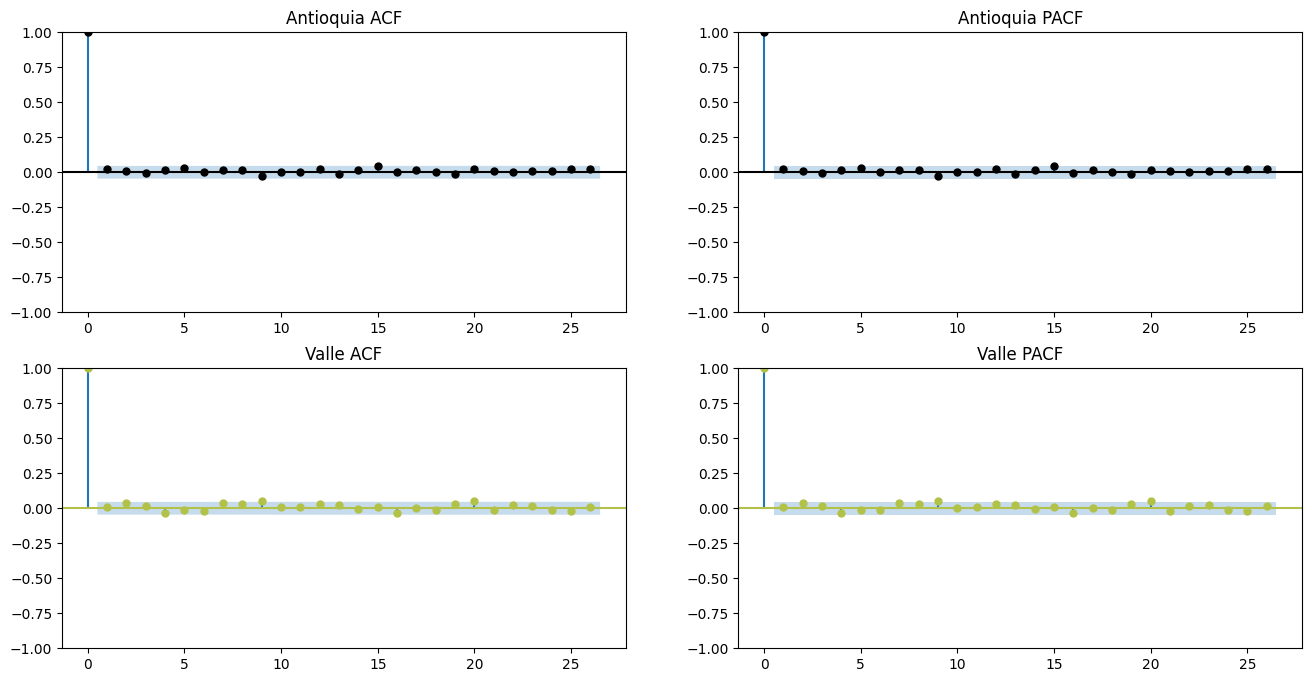

In [ ]:
figs, axs = plt.subplots(2, 2,figsize=(16,8))
fanti.plot_acf(
    ax=axs[0,0],
    title='Antioquia ACF',
    lags=26,
    color='black'
)
fanti.plot_pacf(
    ax=axs[0,1],
    title='Antioquia PACF',
    lags=26,
    color='black',
    method='ywm'
)
fval.plot_acf(
    ax=axs[1,0],
    title='Valle ACF',
    lags=26,
    color='#B2C248'
)
fval.plot_pacf(
    ax=axs[1,1],
    title='Valle PACF',
    lags=26,
    color='#B2C248',
    method='ywm'
)
plt.show()

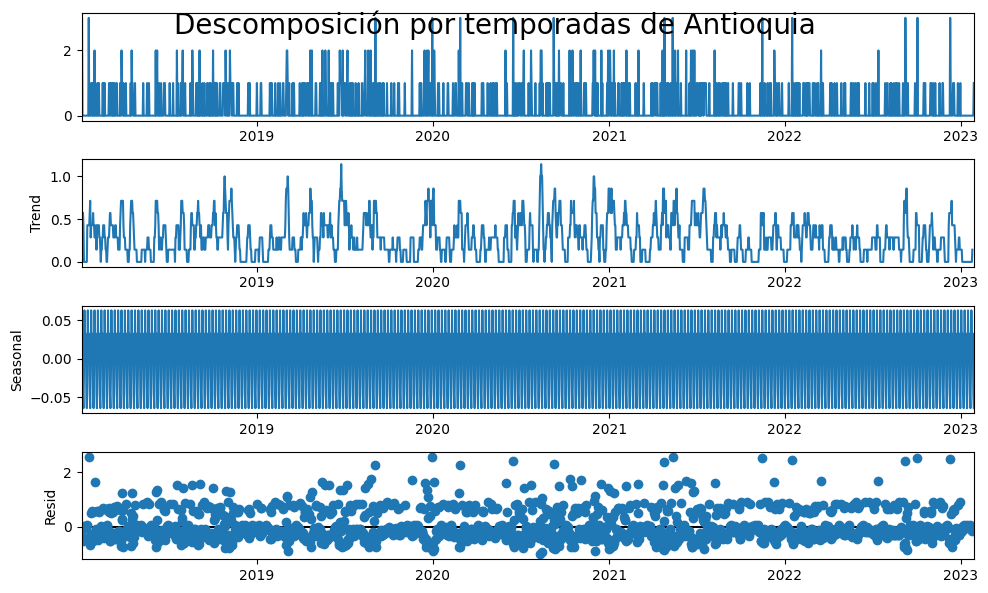

In [ ]:
plt.rc("figure",figsize=(10,6))
fanti.seasonal_decompose(model='add').plot()
plt.suptitle('Descomposición por temporadas de Antioquia',size=20)
plt.show()

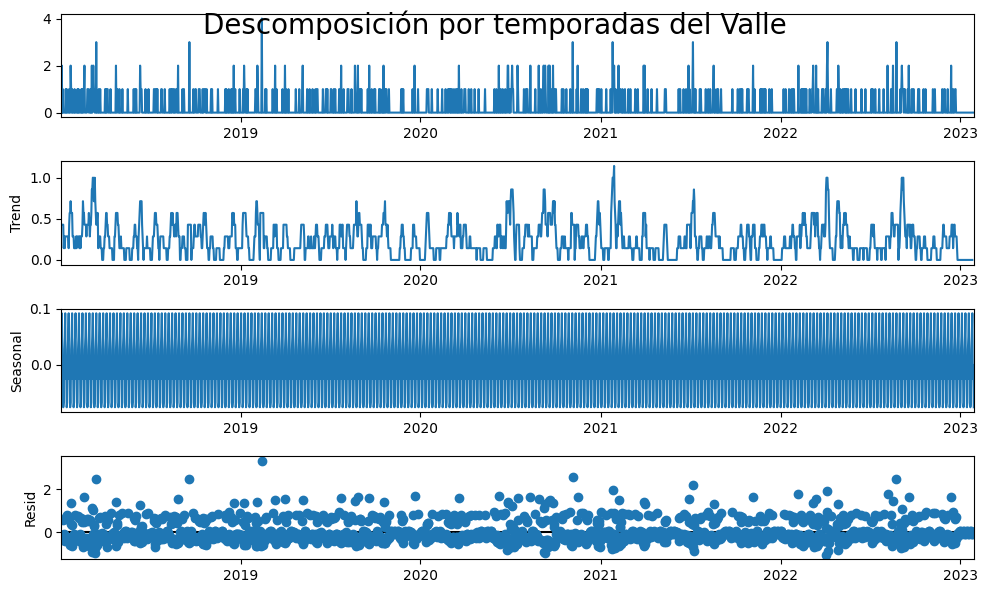

In [ ]:
plt.rc("figure",figsize=(10,6))
fval.seasonal_decompose(model='add').plot()
plt.suptitle('Descomposición por temporadas del Valle',size=20)
plt.show()

In [ ]:
critical_pval = 0.05
print('-'*100)
print('Antioquia Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = fanti.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)
print('Valle del Cauca Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = fval.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Antioquia Augmented Dickey-Fuller results:
the test-stat value is: -42.16
the p-value is 0.0000
the series is stationary
----------------------------------------------------------------------------------------------------
Valle del Cauca Augmented Dickey-Fuller results:
the test-stat value is: -29.25
the p-value is 0.0000
the series is stationary
----------------------------------------------------------------------------------------------------


SCALECAST Univariate

In [ ]:
for f in (fanti,fval):
    f.auto_Xvar_select(
        estimator = 'elasticnet',
        monitor = 'ValidationMetricValue',
        irr_cycles = [365], # try irregular semi-annual seasonality
        max_ar = 50,
        cross_validate=True,
        cvkwargs={
            'k':3,
            'test_length':130,
            'space_between_sets':4,
        }
    )
    print(f)


Forecaster(
    DateStartActuals=2018-01-02T00:00:00.000000000
    DateEndActuals=2023-01-28T00:00:00.000000000
    Freq=D
    N_actuals=1853
    ForecastLength=60
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15']
    TestLength=741
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)
Forecaster(
    DateStartActuals=2018-01-02T00:00:00.000000000
    DateEndActuals=2023-01-28T00:00:00.000000000
    Freq=D
    N_actuals=1853
    ForecastLength=365
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48']
    TestLength=370
    Valid

In [ ]:
fanti.tune_test_forecast(models,feature_importance=True)
best_model_con_uni = fanti.order_fcsts()[0]
fanti.set_estimator('combo')
fanti.manual_forecast(how='weighted')

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

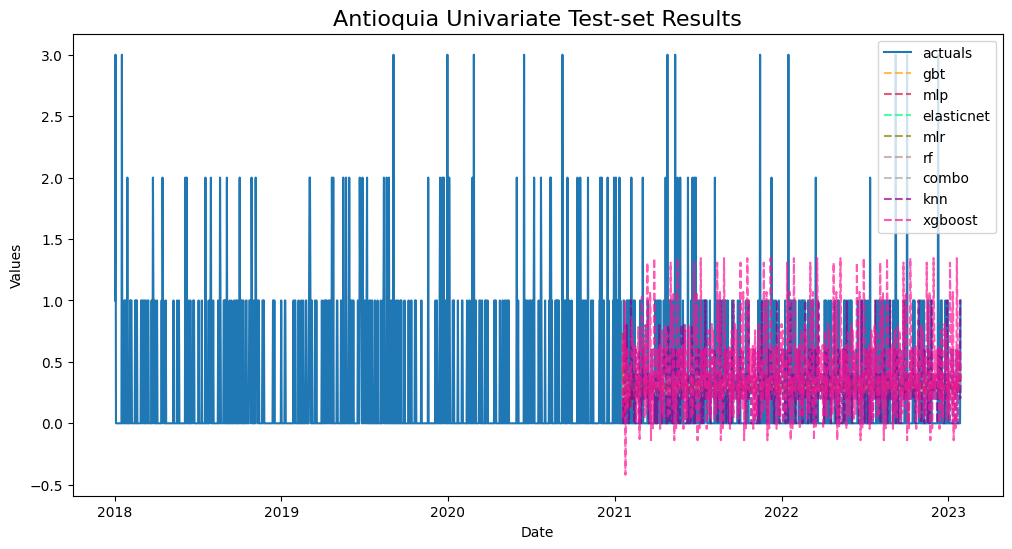

In [ ]:
fanti.plot_test_set(order_by='TestSetRMSE')
plt.title('Antioquia Univariate Test-set Results',size=16)
plt.show()

In [ ]:
fval.tune_test_forecast(models,feature_importance=True)
best_model_con_uni = fval.order_fcsts()[0]
fval.set_estimator('combo')
fval.manual_forecast(how='weighted')

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

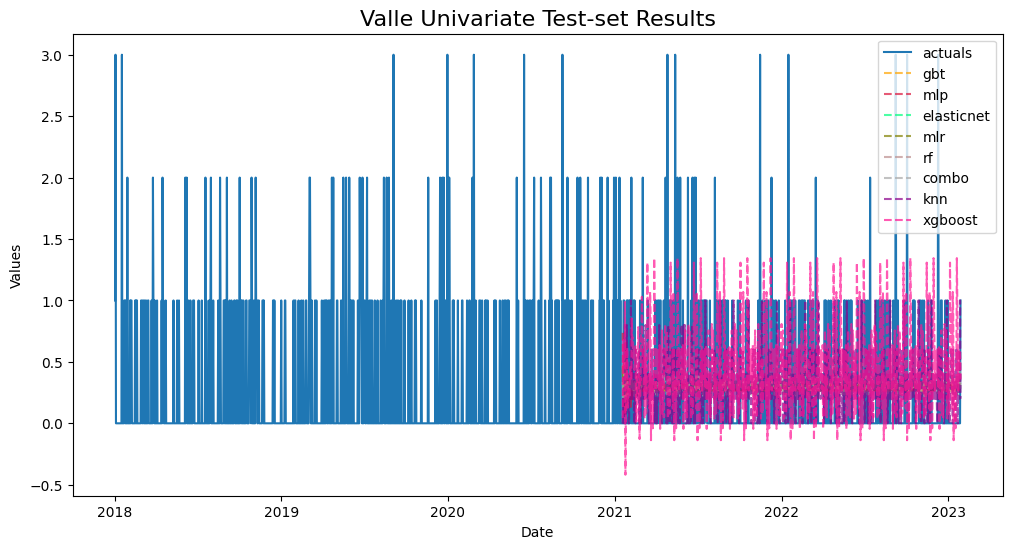

In [ ]:
fanti.plot_test_set(order_by='TestSetRMSE')
plt.title('Valle Univariate Test-set Results',size=16)
plt.show()

In [ ]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = export_model_summaries({'Antioquia':fanti,'Valle':fval},determine_best_by='TestSetRMSE')
ms[
    [
        'ModelNickname',
        'Series',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'best_model'
    ]
]

,ModelNickname,Series,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,best_model
0,gbt,Antioquia,0.5306,-0.0014,0.5305,0.0960,True
1,mlp,Antioquia,0.5323,-0.0079,0.5171,0.1410,False
2,elasticnet,Antioquia,0.5327,-0.0095,0.5579,0.0000,False
3,mlr,Antioquia,0.5333,-0.0116,0.5564,0.0056,False
4,rf,Antioquia,0.5372,-0.0265,0.5581,-0.0007,False
5,combo,Antioquia,0.5382,-0.0305,0.5189,0.1352,False
6,knn,Antioquia,0.5815,-0.2031,0.5119,0.1582,False
7,xgboost,Antioquia,0.6676,-0.5855,0.5256,0.1127,False
8,combo,Valle,0.5202,0.0048,0.4930,0.0825,True
9,mlp,Valle,0.5203,0.0046,0.5064,0.0317,False


In [ ]:
print('-'*100)
for series in ms['Series'].unique():
    print('univariate average test MAPE for {}: {:.4f}'.format(series,ms.loc[ms['Series'] == series,'TestSetRMSE'].mean()))
    print('univariate average test R2 for {}: {:.2f}'.format(series,ms.loc[ms['Series'] == series,'TestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
univariate average test MAPE for Antioquia: 0.5567
univariate average test R2 for Antioquia: -0.11
----------------------------------------------------------------------------------------------------
univariate average test MAPE for Valle: 0.5298
univariate average test R2 for Valle: -0.03
----------------------------------------------------------------------------------------------------


Multivariate

In [ ]:
mvf = MVForecaster(
    fanti,fval,
    names=['Antioquia','Valle'],
    test_length = .4,
    valiation_length = 4,
    cis = True,
    metrics = ['rmse','r2'],
) # init the mvf object
mvf

MVForecaster(
    DateStartActuals=2018-01-02T00:00:00.000000000
    DateEndActuals=2023-01-28T00:00:00.000000000
    Freq=D
    N_actuals=1853
    N_series=2
    SeriesNames=['Antioquia', 'Valle']
    ForecastLength=365
    Xvars=[]
    TestLength=741
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

In [ ]:
mvf.corr()

,Antioquia,Valle
Antioquia,1.0000,-0.0069
Valle,-0.0069,1.0000


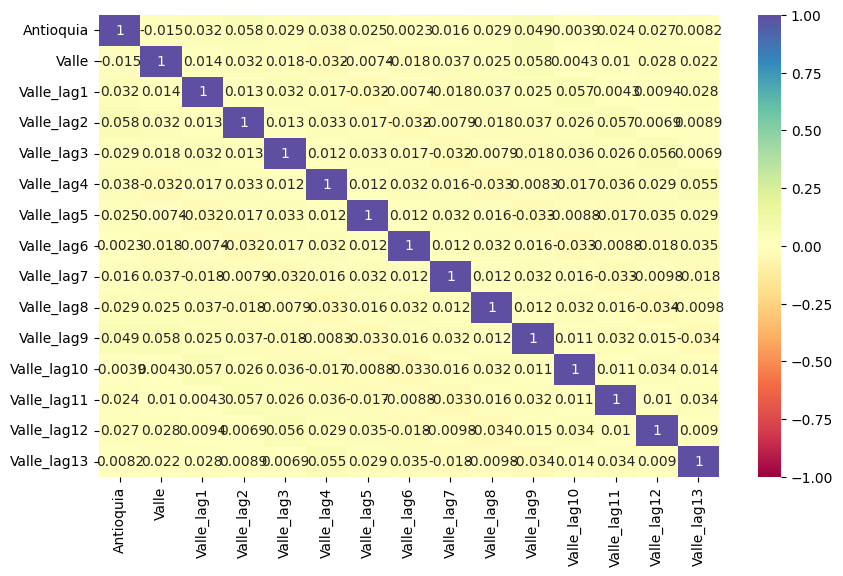

In [ ]:
mvf.corr_lags(
    y='Antioquia',
    x='Valle',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'Spectral',
)
plt.show()

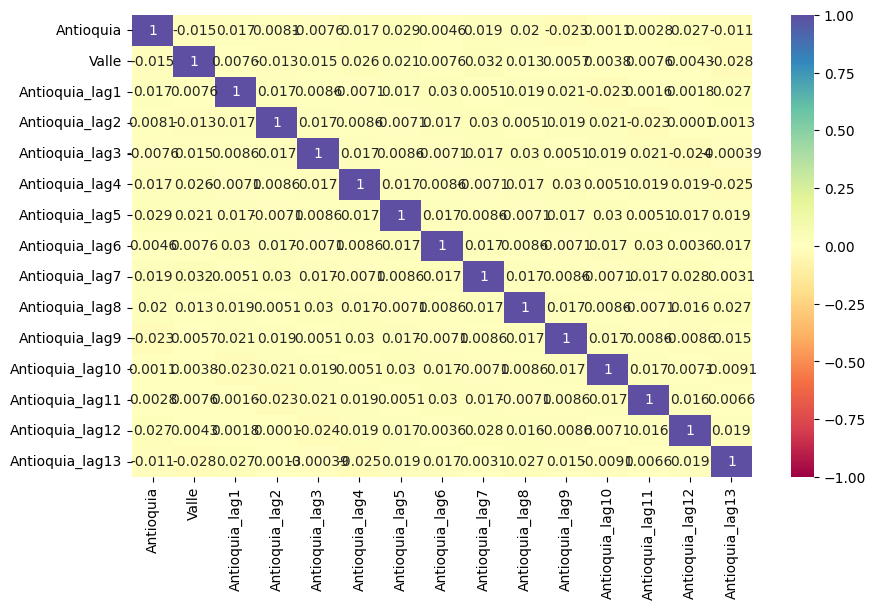

In [ ]:
mvf.corr_lags(
    y='Valle',
    x='Antioquia',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'Spectral',
)
plt.show()

In [ ]:
mvf.set_optimize_on('mean')

In [ ]:
mvf.tune_test_forecast(models)
mvf.set_best_model(determine_best_by='TestSetRMSE')

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

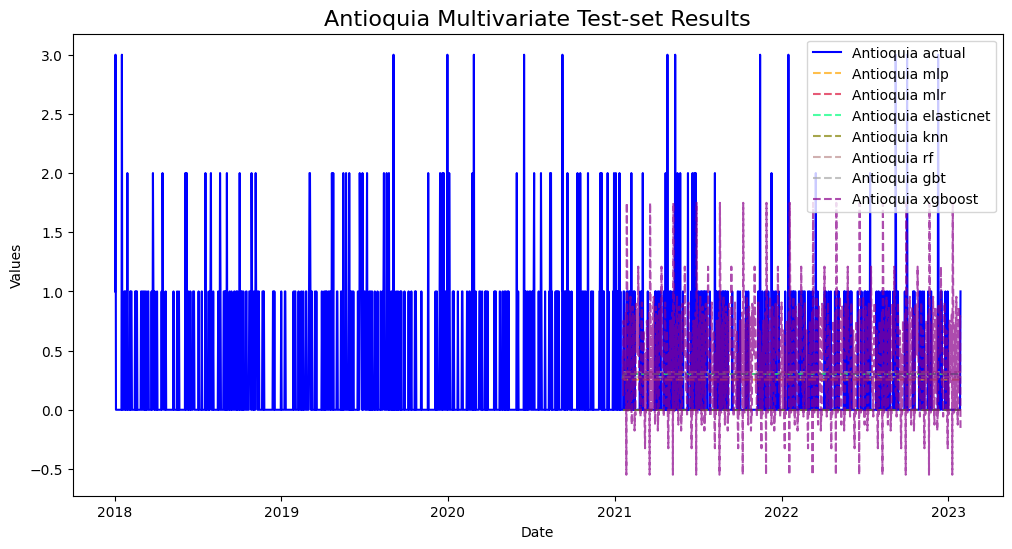

In [ ]:
# not plotting both series at the same time because they have significantly different scales
mvf.plot_test_set(series='Antioquia',put_best_on_top=True)
plt.title('Antioquia Multivariate Test-set Results',size=16)
plt.show()

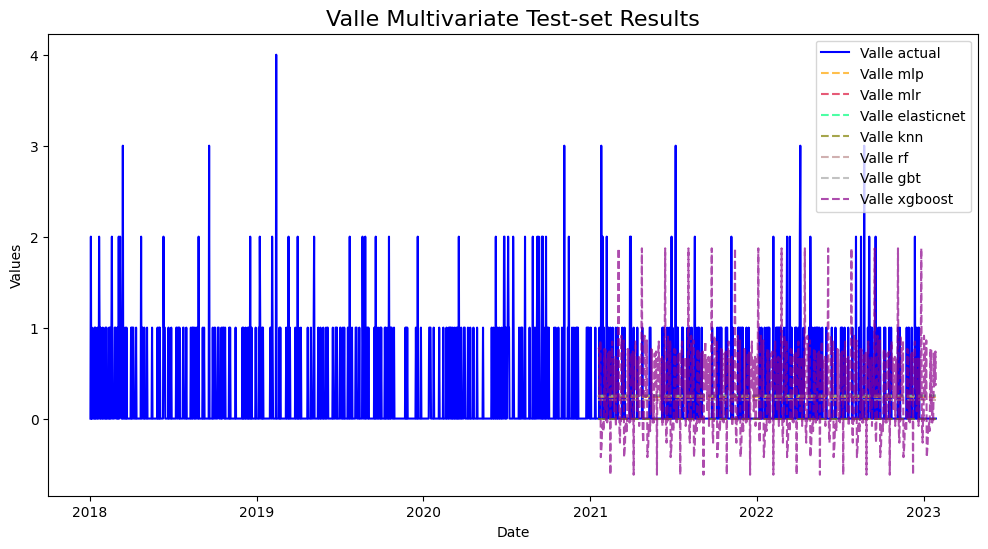

In [ ]:
mvf.plot_test_set(series='Valle',put_best_on_top=True)
plt.title('Valle Multivariate Test-set Results',size=16)
plt.show()

In [ ]:
pd.options.display.max_colwidth = 100
results = mvf.export('model_summaries')
results[
    [
        'ModelNickname',
        'Series',
        'HyperParams',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'Lags'
    ]
]

,ModelNickname,Series,HyperParams,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,Lags
0,mlp,Antioquia,"{'activation': 'relu', 'hidden_layer_sizes': (25,), 'solver': 'adam', 'normalizer': 'minmax'}",0.5302,-0.0001,0.5557,0.0034,3
1,mlr,Antioquia,{'normalizer': None},0.5323,-0.0081,0.5552,0.0052,3
2,elasticnet,Antioquia,"{'alpha': 0.1, 'l1_ratio': 0, 'normalizer': 'scale'}",0.5324,-0.0081,0.5552,0.0051,3
3,knn,Antioquia,{'n_neighbors': 2},0.5878,-0.2290,0.6131,-0.2135,3
4,rf,Antioquia,"{'max_depth': 2, 'n_estimators': 100, 'max_features': 'sqrt', 'max_samples': 1}",0.5343,-0.0156,0.5678,-0.0282,1
5,gbt,Antioquia,"{'max_depth': 2, 'max_features': 'sqrt'}",0.5309,-0.0025,0.5494,0.0257,3
6,xgboost,Antioquia,"{'n_estimators': 150, 'scale_pos_weight': 10, 'learning_rate': 0.2, 'gamma': 0, 'subsample': 0.8}",0.7167,-0.8270,0.5195,0.1299,6
7,stacking,Antioquia,"{'estimators': [('mlr', LinearRegression()), ('elasticnet', ElasticNet(alpha=0.1, l1_ratio=0)), ...",0.6766,-0.6286,0.6840,-0.5039,13
8,mlp,Valle,"{'activation': 'relu', 'hidden_layer_sizes': (25,), 'solver': 'adam', 'normalizer': 'minmax'}",0.5037,-0.0005,0.5155,0.0027,3
9,mlr,Valle,{'normalizer': None},0.5042,-0.0024,0.5157,0.0019,3


In [ ]:
estimators = [
    (
        'mlr',
        LinearRegression()
    ),
    (
        'elasticnet',
        ElasticNet(
            **{
                k:v for k,v in (
                    results.loc[
                        results['ModelNickname'] == 'elasticnet',
                        'HyperParams',
                    ].values[0]
                ).items() if k != 'normalizer'
              }
        )
    ),
    (
        'mlp',
        MLPRegressor(
            **{
                k:v for k,v in (
                    results.loc[
                        results['ModelNickname'] == 'mlp',
                        'HyperParams',
                    ].values[0]
                ).items() if k != 'normalizer'
              }
        )
    )
]

final_estimator = KNeighborsRegressor(
    **{
        k:v for k,v in (
            results.loc[
                results['ModelNickname'] == 'knn',
                'HyperParams',
            ].values[0]
        ).items() if k != 'normalizer'
      }
)

In [ ]:
mvf.add_sklearn_estimator(StackingRegressor,'stacking')
mvf.set_estimator('stacking')
mvf.manual_forecast(estimators=estimators,final_estimator=final_estimator,lags=13)

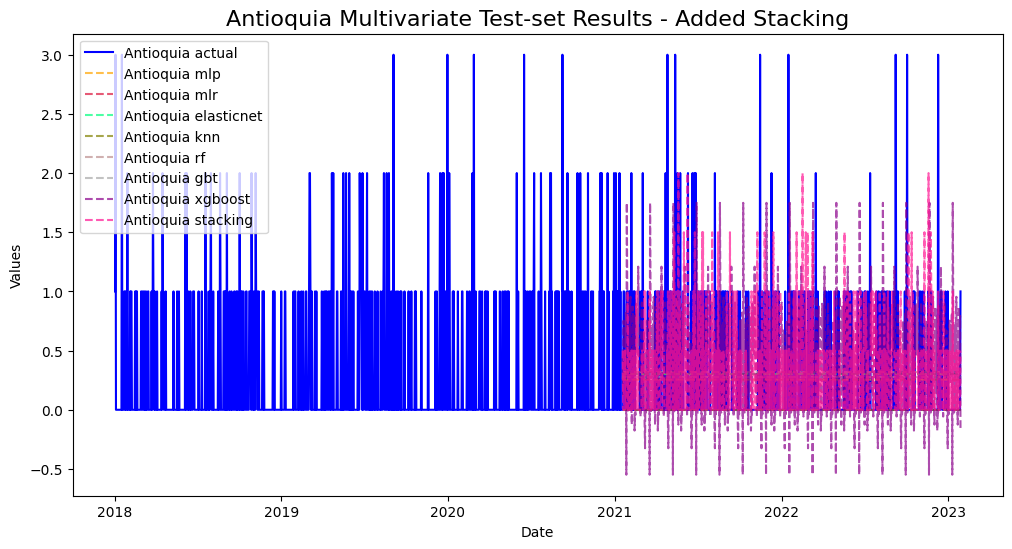

In [ ]:
mvf.plot_test_set(series='Antioquia',put_best_on_top=True)
plt.title('Antioquia Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

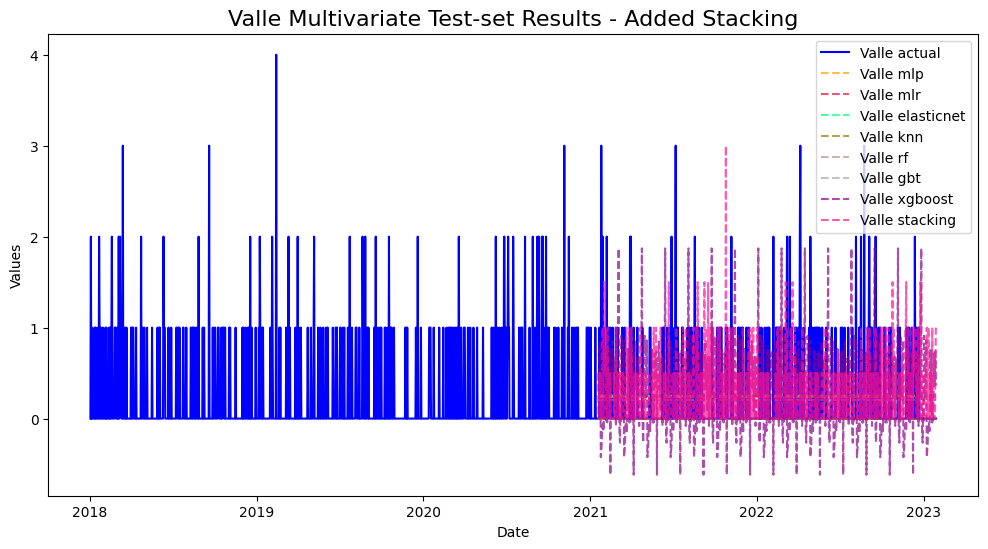

In [ ]:
mvf.plot_test_set(series='Valle',put_best_on_top=True)
plt.title('Valle Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

In [ ]:
mvf.set_best_model(determine_best_by='TestSetRMSE')
results2 = mvf.export('model_summaries')
results2 = results2[
    [
        'ModelNickname',
        'Series',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'Lags',
        'best_model'
    ]
]

results2

,ModelNickname,Series,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,Lags,best_model
0,mlp,Antioquia,0.5302,-0.0001,0.5557,0.0034,3,True
1,mlr,Antioquia,0.5323,-0.0081,0.5552,0.0052,3,False
2,elasticnet,Antioquia,0.5324,-0.0081,0.5552,0.0051,3,False
3,knn,Antioquia,0.5878,-0.2290,0.6131,-0.2135,3,False
4,rf,Antioquia,0.5343,-0.0156,0.5678,-0.0282,1,False
5,gbt,Antioquia,0.5309,-0.0025,0.5494,0.0257,3,False
6,xgboost,Antioquia,0.7167,-0.8270,0.5195,0.1299,6,False
7,stacking,Antioquia,0.6766,-0.6286,0.6840,-0.5039,13,False
8,mlp,Valle,0.5037,-0.0005,0.5155,0.0027,3,True
9,mlr,Valle,0.5042,-0.0024,0.5157,0.0019,3,False


In [ ]:
print('-'*100)
for series in results2['Series'].unique():
    print('multivariate average test MAPE for {}: {:.4f}'.format(series,results2.loc[results2['Series'] == series,'TestSetRMSE'].mean()))
    print('multivariate average test R2 for {}: {:.2f}'.format(series,results2.loc[results2['Series'] == series,'TestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
multivariate average test MAPE for Antioquia: 0.5801
multivariate average test R2 for Antioquia: -0.21
----------------------------------------------------------------------------------------------------
multivariate average test MAPE for Valle: 0.5512
multivariate average test R2 for Valle: -0.22
----------------------------------------------------------------------------------------------------


In [ ]:
best_model_con = (
    results2.loc[results2['Series'] == 'Antioquia']
    .sort_values('TestSetR2',ascending=False)
    .iloc[0,0]
)

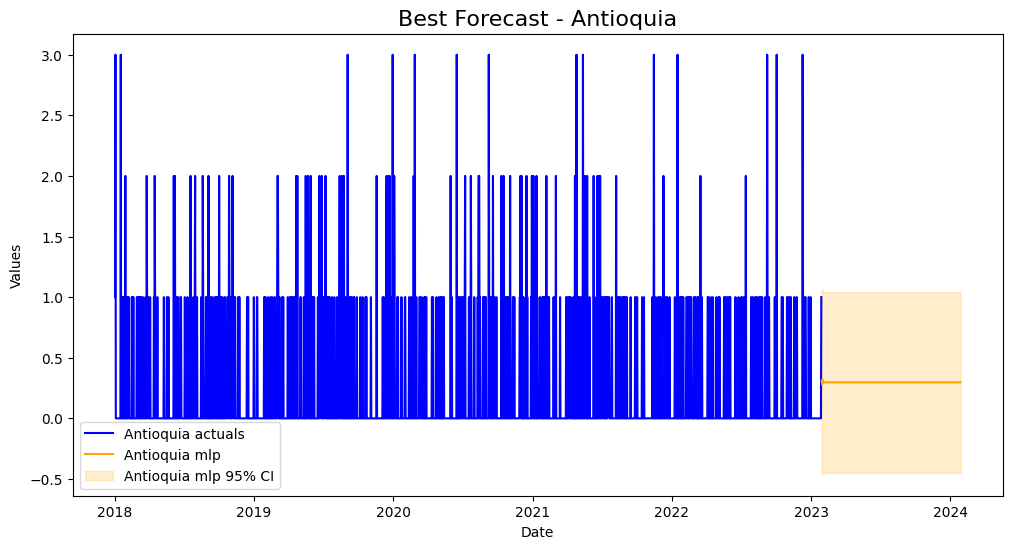

In [ ]:
mvf.plot(series='Antioquia',models=best_model_con,ci=True)
plt.title('Best Forecast - Antioquia',size=16)
plt.show()

In [ ]:
best_model_org = (
    results2.loc[results2['Series'] == 'Valle']
    .sort_values('TestSetR2',ascending=False)
    .iloc[0,0]
)

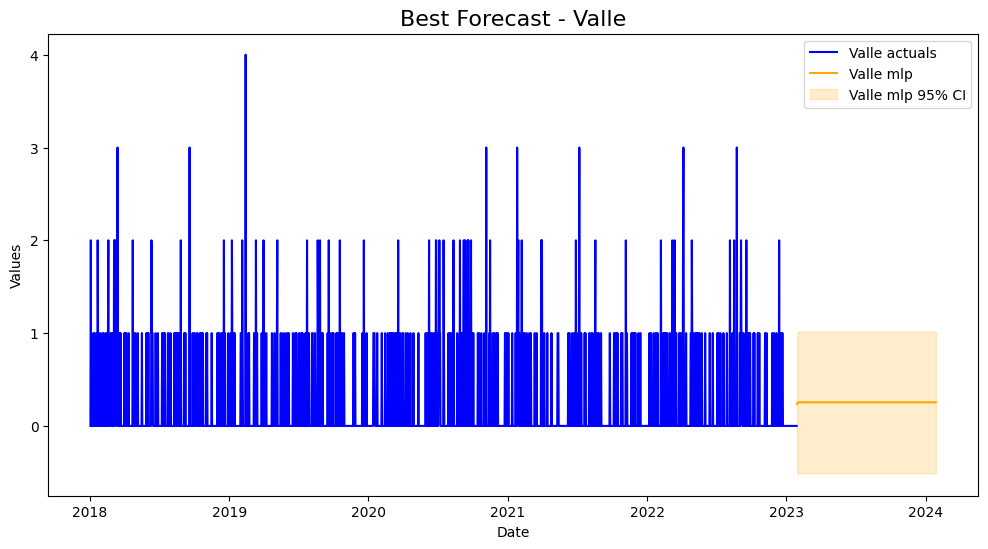

In [ ]:
mvf.plot(series='Valle',models=best_model_org,ci=True)
plt.title('Best Forecast - Valle',size=16)
plt.show()

In [ ]:
from scalecast.Pipeline import Transformer, Reverter, MVPipeline
from scalecast.util import backtest_metrics

def mvforecaster(mvf):
    mvf.add_seasonal_regressors('month','quarter',raw=False,sincos=True)
    mvf.tune_test_forecast(
        models=[best_model_con,best_model_org],
    )

pipeline = MVPipeline(
    steps = [('Forecast',mvforecaster)],
    validation_length = 4,
)

In [ ]:
backtest_results = pipeline.backtest(
    fanti,
    fval,
    cis=False,
    test_length = 0,
    fcst_length = 52,
    jump_back = 4,
    n_iter = 3,
)

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

In [ ]:
backtest_metrics(
    backtest_results,
    mets=['rmse','r2'],
    names=['Antioquia','Valle'],
)

Iter0   Iter1   Iter2  Average
Series    Model Metric                                 
Antioquia mlp   rmse    0.5249  0.5672  0.5505   0.5475
                r2     -0.0177 -0.2443 -0.1724  -0.1448
Valle     mlp   rmse    0.3635  0.4338  0.4004   0.3992
                r2     -0.0542 -0.3390 -0.0345  -0.1426